In [38]:
import gurobipy as gp # solver
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
from InstanceClass import Instance # custom class built to load and encode .json files (instances)

In [40]:
instance = Instance(path="toy_instance.json")
instance.build_instance()
instance.variables

{'NP': 5,
 'NC': 3,
 'NA': 3,
 'H': 5,
 'GAIN': [20, 15, 15, 20, 10],
 'PENALTIES': array([[0., 0., 0., 3., 6.],
        [0., 0., 0., 3., 6.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 3., 6.],
        [0., 0., 0., 0., 0.]]),
 'STAFF_QUALIFICATIONS': array([[1., 1., 1.],
        [1., 1., 0.],
        [0., 0., 1.]]),
 'COST_PROJECT': array([[1., 1., 1.],
        [1., 2., 0.],
        [1., 0., 2.],
        [0., 2., 1.],
        [0., 0., 2.]]),
 'CONGES': array([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])}

In [68]:
gain_max = sum(instance.variables['GAIN']) # 1-gain/gain_max et on minimise tout
horizon_max = instance.variables['H']
nbr_jour_max = instance.variables['H']

print('Gain maximal possible: ', gain_max)
print('Horizon maximal: ', horizon_max)
print('Nombre de jours maximal pour un projet: ', nbr_jour_max)

Gain maximal possible:  80
Horizon maximal:  5
Nombre de jours maximal pour un projet:  5


In [42]:
#points = np.load("PARETO_POINTS_small.npz")["points"]

In [69]:
#not_dominated_solutions = points

not_dominated_solutions = np.array([[65, 4, 1], [55, 3, 1], [40, 2, 1], [20, 1, 1]])

print(not_dominated_solutions)

[[65  4  1]
 [55  3  1]
 [40  2  1]
 [20  1  1]]


In [70]:
#Normalize

not_dominated_solutions_normalize = np.ones((not_dominated_solutions.shape[0],not_dominated_solutions.shape[1]))

not_dominated_solutions_normalize[:,0] = 1 -(not_dominated_solutions[:,0]/gain_max)

not_dominated_solutions_normalize[:,1] = (not_dominated_solutions[:,1]/horizon_max)

not_dominated_solutions_normalize[:,2] = (not_dominated_solutions[:,2]/nbr_jour_max)

print(not_dominated_solutions_normalize)

[[0.1875 0.8    0.2   ]
 [0.3125 0.6    0.2   ]
 [0.5    0.4    0.2   ]
 [0.75   0.2    0.2   ]]


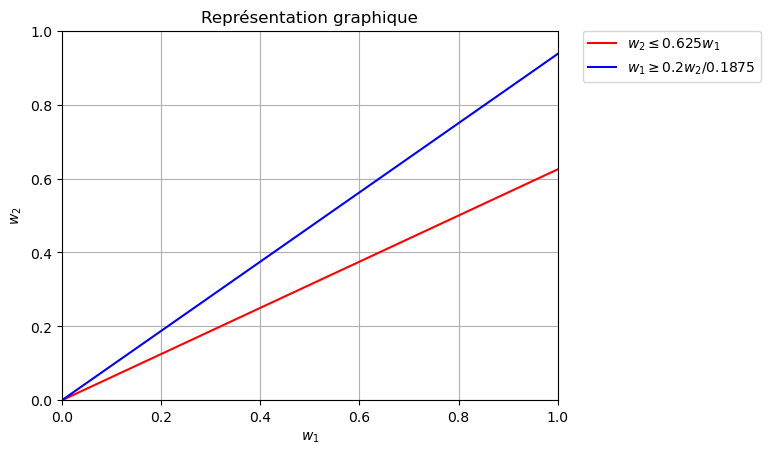

In [71]:
# -- Construction des droites associées aux contraintes --
w1 = np.linspace(0, 1, 100)

# poids
# (C1) : le planning 1 est au moins aussi attractif que le planning 2
w2_C1 = 0.625*w1
# (C2) : le planning 2 est au moins aussi attractif que le planning 3
w2_C2 = 0.9375*w1   



# -- Dessin des droites associées aux contraintes --
plt.plot(w1, w2_C1, 'r', label = '$w_2 \leq 0.625 w_1$')
plt.plot(w1, w2_C2, 'b', label = '$w_1 \geq  0.2w_2/0.1875$')



# -- Définition des paramètres du graphique --
plt.grid()
plt.xlim((0, 1)) 
plt.ylim((0, 1))
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title('Représentation graphique')


# -- Affichage du graphique --
plt.show()

In [51]:
# dim : int
dim = 3
# Nombre plannings
nbr_planning = not_dominated_solutions.shape[0]

In [72]:
# Implémentation Python
epsilon = 0
m = gp.Model("Preferences")

# W : Dict[int, Var]
W = {d : m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'w{d}') for d in range(1, dim + 1)}

# PlanningDictLinExpr : Dict[int, LinExpr]
PlanningsDictLinExpr = {l+1 : gp.quicksum([W[i+1]*not_dominated_solutions_normalize[l][i] for i in range(dim)]) for l in range(nbr_planning)}

# Contrainte 1 : le planning 1 est au moins aussi attractif que le planning 2
m.addConstr(PlanningsDictLinExpr[1] >= PlanningsDictLinExpr[2] + epsilon, name="C_1")

# Contrainte 2 : le planning 2 est au moins aussi attractif que le planning 3
m.addConstr(PlanningsDictLinExpr[2] >= PlanningsDictLinExpr[3] + epsilon , name="C_2")


# Contrainte 4 : Normalisation
m.addConstr(gp.quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

# Solution : dict[int : List[int]]
 # Solution[k] ensemble des lecteurs auxquels est préféré le lecteur k
Solution = {l+1 : list() for l in range(nbr_planning)}

for i in range(1, nbr_planning):
    for j in range(i+1, nbr_planning+1):
        obj1 = PlanningsDictLinExpr[i] - PlanningsDictLinExpr[j]
        m.setObjective(obj1, GRB.MAXIMIZE)
        m.optimize()
        if m.objVal < 0:
            Solution[j].append(i)
        else:
            obj2 = - obj1
            m.setObjective(obj2, GRB.MAXIMIZE)
            m.optimize()
            if m.objVal < 0:
                Solution[i].append(j)



In [73]:
print(Solution)

{1: [4], 2: [], 3: [], 4: []}
